# Calculating error in sea surface height for major ice sheets at different satellite data availability levels

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyslfp import FingerPrint, IceModel
from joblib import Parallel, delayed

from Part_III_Project import sea_surface_height_change

Set up latitude range:

In [2]:
latitude_max = np.linspace(1, 90, 1000)
latitude_min = -latitude_max

Set up ice sheet melts:

In [3]:
fp = FingerPrint()
fp.set_state_from_ice_ng(version=IceModel.ICE7G, date=0.0)

error_output = pd.DataFrame(
    {
        "latitude_min": latitude_min,
        "latitude_max": latitude_max,
        "greenland_error": np.zeros_like(latitude_min),
        "west_antarctic_error": np.zeros_like(latitude_min),
        "east_antarctic_error": np.zeros_like(latitude_min),
    }
)

# Define ice sheet configurations
ice_sheets = {
    "greenland": {"load_func": fp.greenland_load, "error_col": "greenland_error"},
    "west_antarctic": {
        "load_func": fp.west_antarctic_load,
        "error_col": "west_antarctic_error",
    },
    "east_antarctic": {
        "load_func": fp.east_antarctic_load,
        "error_col": "east_antarctic_error",
    },
}

Calculates the error in sea surface height change estimates for different combinations of satellite data availability for ice sheet melts in Greenland, West Antarctica, and East Antarctica

Non-parallel version:

In [4]:
for ice_sheet_name, config in ice_sheets.items():
    # Get the direct load for this ice sheet
    direct_load = config["load_func"]()

    # Calculate sea level changes
    (
        sea_level_change,
        displacement,
        gravitational_potential_change,
        angular_velocity_change,
    ) = fp(direct_load=direct_load)

    sea_surface_height_change_result = sea_surface_height_change(
        fp, sea_level_change, displacement, angular_velocity_change
    )

    # Calculate mean sea level change once per ice sheet
    mean_sea_level_change = fp.mean_sea_level_change(direct_load)

    # Calculate errors for each latitude band
    for i in range(len(latitude_min)):
        ##### EXTRACT THIS HERE TO FUNCTION #####
        altimetry_projection = fp.altimetry_projection(
            latitude_min=latitude_min[i], latitude_max=latitude_max[i], value=0
        )

        altimetry_projection_integral = fp.integrate(altimetry_projection)
        altimetry_weighting_function = (
            altimetry_projection / altimetry_projection_integral
        )

        mean_sea_level_change_estimate = fp.integrate(
            altimetry_weighting_function * sea_surface_height_change_result
        )

        # Calculate relative error
        error = (
            100
            * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
            / np.abs(mean_sea_level_change)
        )

        error_output.loc[i, config["error_col"]] = error

KeyboardInterrupt: 

Parallel version:

In [5]:
def process_ice_sheet(ice_sheet_name, config, latitude_min, latitude_max, fp):
    """Process a single ice sheet and return errors for all latitude bands."""
    # Get the direct load for this ice sheet
    direct_load = config["load_func"]()

    # Calculate sea level changes
    (
        sea_level_change,
        displacement,
        gravitational_potential_change,
        angular_velocity_change,
    ) = fp(direct_load=direct_load)

    sea_surface_height_change_result = sea_surface_height_change(
        fp, sea_level_change, displacement, angular_velocity_change
    )

    # Calculate mean sea level change once per ice sheet
    mean_sea_level_change = fp.mean_sea_level_change(direct_load)

    # Calculate errors for each latitude band
    errors = []
    for i in range(len(latitude_min)):
        altimetry_projection = fp.altimetry_projection(
            latitude_min=latitude_min[i], latitude_max=latitude_max[i], value=0
        )

        altimetry_projection_integral = fp.integrate(altimetry_projection)
        altimetry_weighting_function = (
            altimetry_projection / altimetry_projection_integral
        )

        mean_sea_level_change_estimate = fp.integrate(
            altimetry_weighting_function * sea_surface_height_change_result
        )

        # Calculate relative error
        error = (
            100
            * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
            / np.abs(mean_sea_level_change)
        )

        errors.append((i, error))

    return ice_sheet_name, config["error_col"], errors


# Parallel execution
results = Parallel(n_jobs=-1, verbose=5)(
    delayed(process_ice_sheet)(ice_sheet_name, config, latitude_min, latitude_max, fp)
    for ice_sheet_name, config in ice_sheets.items()
)

# Populate error_output with results
for ice_sheet_name, error_col, errors in results:
    for i, error in errors:
        error_output.loc[i, error_col] = error

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.4s finished


In [6]:
error_output.to_csv("traditional_method_errors.csv", index=True)
# error_output = pd.read_csv("traditional_method_errors.csv", index=True)

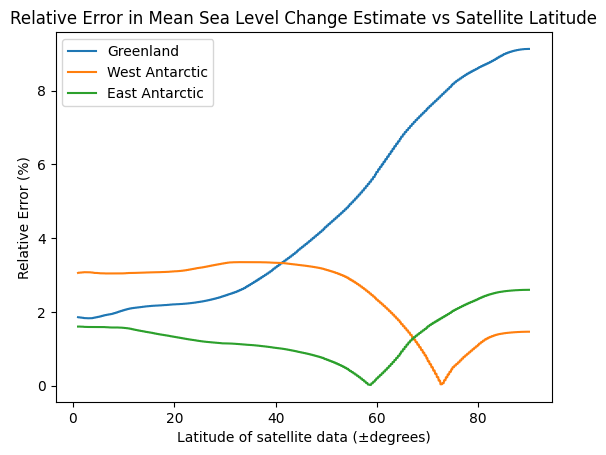

In [7]:
plt.figure()
plt.plot(
    -error_output["latitude_min"],
    error_output["greenland_error"],
    label="Greenland",
)
plt.plot(
    -error_output["latitude_min"],
    error_output["west_antarctic_error"],
    label="West Antarctic",
)
plt.plot(
    -error_output["latitude_min"],
    error_output["east_antarctic_error"],
    label="East Antarctic",
)
plt.xlabel("Latitude of satellite data (±degrees)")
plt.ylabel("Relative Error (%)")
plt.title("Relative Error in Mean Sea Level Change Estimate vs Satellite Latitude")
plt.legend()
plt.show()